In [3]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np

# Load a pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Define the patch size and initialize the patch with random values
patch_size = (50, 50)
patch = torch.rand((3, *patch_size), requires_grad=True)

# Define an optimizer for the patch
optimizer = torch.optim.Adam([patch], lr=0.01)

# Define transformation functions
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load an example image and apply transformations
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Function to apply patch to an image at a given location
def apply_patch(image, patch, location):
    patched_image = image.clone()
    patched_image[:, :, location[0]:location[0]+patch.size(1), location[1]:location[1]+patch.size(2)] = patch
    return patched_image

# Define target class (e.g., 'tabby cat')
target_class = 281

# Adversarial training loop
def train_patch(image_path, target_class, num_steps=100):
    image = load_image(image_path)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch to the image at a random location
        x_offset = np.random.randint(0, 224 - patch_size[0])
        y_offset = np.random.randint(0, 224 - patch_size[1])
        patched_image = apply_patch(image, patch, (x_offset, y_offset))
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Calculate loss (maximize target class probability)
        loss = -output[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return patch

# Train the adversarial patch on an example image
trained_patch = train_patch("example.png", target_class)

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch.pt")

/Users/arunesh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/arunesh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0, Loss: -0.5183781981468201
Step 10, Loss: -1.4124999046325684
Step 20, Loss: -1.2739139795303345
Step 30, Loss: -3.2595388889312744
Step 40, Loss: -3.9805245399475098
Step 50, Loss: -2.648625612258911
Step 60, Loss: -3.4420735836029053
Step 70, Loss: -4.329965591430664
Step 80, Loss: -6.040412902832031
Step 90, Loss: -8.731098175048828


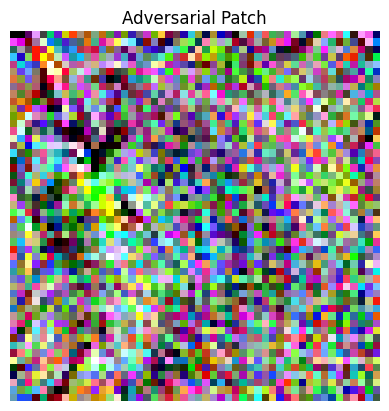

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the adversarial patch from the .pt file
patch = torch.load('adversarial_patch.pt')

# Convert tensor to numpy array and permute dimensions for visualization
# PyTorch uses [C, H, W], convert it to [H, W, C] for Matplotlib
patch_np = patch.detach().cpu().numpy()
patch_np = np.transpose(patch_np, (1, 2, 0))

# Ensure values are in the range [0, 1] for display
patch_np = np.clip(patch_np, 0, 1)

# Display the patch using Matplotlib
plt.imshow(patch_np)
plt.axis('off')  # Turn off axis labels
plt.title('Adversarial Patch')
plt.show()

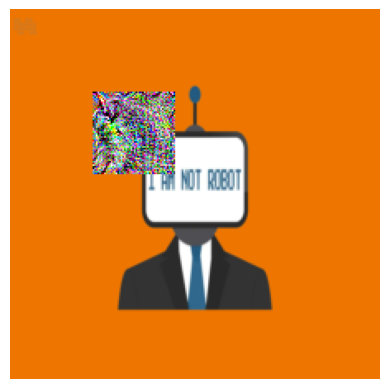

Predicted class after applying patch: 281


In [6]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Load the adversarial patch from the .pt file
patch = torch.load('adversarial_patch.pt')

# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# Function to apply patch to an image at a given location
def apply_patch(image, patch, location):
    patched_image = image.clone()
    # Ensure the patch fits within the image dimensions
    patched_image[:, :, location[0]:location[0]+patch.size(1), location[1]:location[1]+patch.size(2)] = patch
    return patched_image

# Visualize the patched image
def visualize_image(image_tensor):
    # Convert tensor to numpy array for visualization
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()

# Example usage
image_path = "example.png"
image = load_image(image_path)

# Apply the adversarial patch at a specific location (e.g., top-left corner)
x_offset, y_offset = 50, 50  # Adjust these values as needed
patched_image = apply_patch(image, patch, (x_offset, y_offset))

# Visualize the patched image
visualize_image(patched_image)

# Classify the patched image using the model
output = model(patched_image)
_, predicted_class = torch.max(output, 1)
print(f"Predicted class after applying patch: {predicted_class.item()}")